# ELP.10 - GABA Side Learning Y-Maze
<hr style="border:2px solid gray"> </hr>

**Author:** Henrique Galante | henrique.galante@ur.de

**Last Updated:** April 2022

This supplement provides the entire R script and output of the statistical analysis performed and figures produced, in their original form. It is presented in the spirit of open and transparent science, but has not been carefully curated.

## Data handling
<hr style="border:0.5px solid gray"> </hr>

### Load packages

In [1]:
require(reshape2) # For data handling
require(lme4) # Linear mixed-effects models
require(DHARMa) # Evaluate model fit
require(car) # Anova() function [instead of base R anova()]
require(emmeans) # Post-hoc analysis on the model

Loading required package: reshape2

Loading required package: lme4

Loading required package: Matrix

Loading required package: DHARMa

Warning message:
“package ‘DHARMa’ was built under R version 4.1.2”
This is DHARMa 0.4.5. For overview type '?DHARMa'. For recent changes, type news(package = 'DHARMa')

Loading required package: car

Loading required package: carData

Warning message:
“package ‘carData’ was built under R version 4.1.2”
Loading required package: emmeans

Warning message:
“package ‘emmeans’ was built under R version 4.1.2”


### Clean-up

In [9]:
rm(list = ls()) # Remove variables/objects
graphics.off() # Close any open graphics

### Load data

In [10]:
ELP_10 = read.csv("./Data/ELP_10_GABA_side_learning_Y_maze.csv", header = TRUE, stringsAsFactors = FALSE, sep = ";")
head(ELP_10, n = 1) # Check if data was imported correctly

,Collection_Date,Time_Collection,Experimentor,Temperature,Colony_Origin,Starvation_Period,Donor_Colony,Recipient_Colony,Ant_ID,Visit,⋯,Initial_Decision,Final_Decision,Number_Relocations,In_Duration,Drinking_Duration,Out_Duration,Bridge_Nest_Duration,Total_Duration_Minutes,Trophallaxis,Full
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,⋯,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>
1,11.04.22,09:00,Laura Neubauer,"23,9",5th November - Spain,4-days,32,29,1,2,⋯,L,L,0,18,56,11,500,"9,8",NA,NA


### Column descriptions

| Column Name            | Description |
| ---:                   | :---        |
| **Collection_Date**        | Testing date       |
| **Time_Collection**        | Starting time of data collection        |
| **Experimentor**           | Name of the person collecting the data       |
| **Temperature**            | Room temperature at start of data collection        |
| **Colony_Origin**          | Country of origin and time of arrival to the lab of the colonies used       |
| **Starvation_Period**      | How long were the ants deprived of food for        |
| **Donor_Colony**           | ID of the colony where the ant originated from (naive colony)       |
| **Recipient_Colony**       | ID of the colony the ant was placed in (non-naive colony)        |
| **Ant_ID**                 | ID of the ant used       |
| **Visit**                  | Visit number        |
| **Solution**               | Which solution was each ant tested with       |
| **Reward_Side**            | In which side of the Y-maze was the solution placed        |
| **Time_Since_Marking**     | How long was the ant in the nest for between marking (visit 1) and visit 2       |
| **Initial_Decision**       | Which side of the Y-maze the ant first crossed a 2cm line        |
| **Final_Decision**         | Which side of the Y-maze the ant first touched the solution drop       |
| **Number_Relocations**     | How many times was the ant relocated during a visit due to escaping or falling on water        |
| **In_Duration**            | How long in seconds did the ant take to reach the drop of solution       |
| **Drinking_Duration**      | How long in seconds did the ant take feeding on the drop of solution        |
| **Out_Duration**           | How long in seconds did the ant take to return to the bridge       |
| **Bridge_Nest_Duration**   | How long in seconds did the ant take to return to the colony       |
| **Total_Duration_Minutes** | How long in minutes did the ant take in the whole trip       |
| **Trophallaxis**           | Was the ant seen doing trophallaxis after returning to the colony from the visit        |
| **Full**                   | Was the ant visibly full (expanded gaster) at the beggining of the visit       | 

### Unblind the solutions

In [11]:
ELP_10$Solution = ifelse(ELP_10$Solution == "G", "0.734mM GABA", "Control")

### Get a binary (right/wrong) initial and final decision and check how many ants switched between their initial and final decision

In [12]:
ELP_10$Initial_Decision_Binary = ifelse(ELP_10$Initial_Decision == ELP_10$Reward_Side, 1, 0)
ELP_10$Final_Decision_Binary = ifelse(ELP_10$Final_Decision == ELP_10$Reward_Side, 1, 0)
ELP_10$Switched_Decision_Binary = ifelse(ELP_10$Initial_Decision_Binary == ELP_10$Final_Decision_Binary, 0, 1)
paste0("Ants switched their final decision in ", round(sum(ELP_10$Switched_Decision_Binary) / nrow(ELP_10) * 100, 0), "% of the visits!")

[1] "Ants switched their final decision in 2% of the visits!"

### Sample size per solution per side

In [13]:
table(ELP_10$Solution, ELP_10$Reward_Side) / 4

              
                L  R
  0.734mM GABA 16 16
  Control      16 16

### Ensure that the Bridge_Nest_Duration for visit 2 is the same as the time since marking for visit 2

In [14]:
for (i in 1:nrow(ELP_10)) {
  if (ELP_10$Visit[i] == "2" & !is.na(ELP_10$Bridge_Nest_Duration[i])) {
    if (ELP_10$Bridge_Nest_Duration[i] != ELP_10$Time_Since_Marking[i]) {
      print(paste0("Warning: Row ", i, " was changed from ", ELP_10$Bridge_Nest_Duration[i], "s to ", ELP_10$Time_Since_Marking[i], "s!"))
      ELP_10$Bridge_Nest_Duration[i] = ELP_10$Time_Since_Marking[i]
    }
  }
  else if (ELP_10$Visit[i] == "2" & is.na(ELP_10$Bridge_Nest_Duration[i])) {
    ELP_10$Bridge_Nest_Duration[i] = ELP_10$Time_Since_Marking[i]
    print(paste0("Warning: Row ", i, " was changed and Bridge_Nest_Duration was NA!"))
  }
}

[1] "Warning: Row 245 was changed from 2700s to 2580s!"


### Create time intervals to group replicates based on time since marking

In [15]:
for (i in 1:nrow(ELP_10)) {
  if (ELP_10$Time_Since_Marking[i] <= 1800) {
    ELP_10$TSM_Bin[i] = "0-30"
  }
  else if (ELP_10$Time_Since_Marking[i] > 1800 & ELP_10$Time_Since_Marking[i] <= 3600) {
    ELP_10$TSM_Bin[i] = "30-60"
  }
  else {
    print("Warning: Undefined bins!")
  }
}

### Sample size per solution per time bin and per side

In [16]:
table(ELP_10$Solution, ELP_10$TSM_Bin, ELP_10$Reward_Side) / 4

, ,  = L

              
               0-30 30-60
  0.734mM GABA    8     8
  Control         8     8

, ,  = R

              
               0-30 30-60
  0.734mM GABA    8     8
  Control         8     8


### Ensure relevant columns are factors

In [17]:
ELP_10$Collection_Date = as.factor(ELP_10$Collection_Date)
ELP_10$Time_Collection = as.factor(ELP_10$Time_Collection)
ELP_10$Experimentor = as.factor(ELP_10$Experimentor)
ELP_10$Starvation_Period = as.factor(ELP_10$Starvation_Period)
ELP_10$Donor_Colony = as.factor(ELP_10$Donor_Colony)
ELP_10$Recipient_Colony = as.factor(ELP_10$Recipient_Colony)

ELP_10$Visit = as.factor(ELP_10$Visit)
ELP_10$Solution = as.factor(ELP_10$Solution)
ELP_10$Solution = relevel(ELP_10$Solution, "Control")
ELP_10$Reward_Side = as.factor(ELP_10$Reward_Side)
ELP_10$TSM_Bin = as.factor(ELP_10$TSM_Bin)

ELP_10$Initial_Decision_Binary = as.factor(ELP_10$Initial_Decision_Binary)
ELP_10$Final_Decision_Binary = as.factor(ELP_10$Final_Decision_Binary)

## Data analysis
<hr style="border:0.5px solid gray"> </hr>

### Preliminary question
#### Do initial and final choices differ significantly?

In [18]:
initial_final_diff = melt(ELP_10, measure.vars = c("Initial_Decision_Binary", "Final_Decision_Binary"))
initial_final_diff$value = as.factor(initial_final_diff$value)
head(initial_final_diff, n = 1) # Check if data was imported correctly

,Collection_Date,Time_Collection,Experimentor,Temperature,Colony_Origin,Starvation_Period,Donor_Colony,Recipient_Colony,Ant_ID,Visit,⋯,Drinking_Duration,Out_Duration,Bridge_Nest_Duration,Total_Duration_Minutes,Trophallaxis,Full,Switched_Decision_Binary,TSM_Bin,variable,value
,<fct>,<fct>,<fct>,<chr>,<chr>,<fct>,<fct>,<fct>,<int>,<fct>,⋯,<int>,<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<fct>,<fct>,<fct>
1,11.04.22,09:00,Laura Neubauer,"23,9",5th November - Spain,4-days,32,29,1,2,⋯,56,11,500,"9,8",NA,NA,0,0-30,Initial_Decision_Binary,1


In [20]:
diff_model = glmer(value ~ variable + (1|Starvation_Period) + (1|Collection_Date), data = initial_final_diff, family = binomial, glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))
Anova(diff_model)

boundary (singular) fit: see ?isSingular



,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
variable,0.07752936,1,0.7806739


In [21]:
e = emmeans(diff_model, ~variable, type = "response")
pairs(e)

 contrast                                        odds.ratio    SE  df null
 Initial_Decision_Binary / Final_Decision_Binary       0.95 0.176 Inf    1
 z.ratio p.value
  -0.278  0.7807

Tests are performed on the log odds ratio scale 

There is no siginificant difference between inital and final decision, hence we will only use final decision for further analysis as this is a better measure of learning considering it allows the individuals to correct a potentially wrong initial choice (which could be attributed to exploration)
### Modelling
Instead of building a super complicated model with all possible interactions, we will consider two-way interactions (three-way+ interactions are almost impossible to interpret biologically) exclusively: how do pairs of variables affect each other?

y ~ (a + b + c)^2 gets all two way combinations of the variables in the brackets, hence being a faster way of getting this model:

y ~ a + b + c + a:b + a:c + b:c

We start with the maximal model below and simplify gradually by removing terms that explain little to no variation in this way obtaining a simpler, equally, if not more, meaningful.

In [22]:
mod1 = glmer(Final_Decision_Binary ~ (Reward_Side + Solution + TSM_Bin + Visit)^2  +
               (1|Starvation_Period) + (1|Collection_Date), 
             data = ELP_10, family = "binomial", glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))

boundary (singular) fit: see ?isSingular



#### Is the maximal model a good fit to the data?

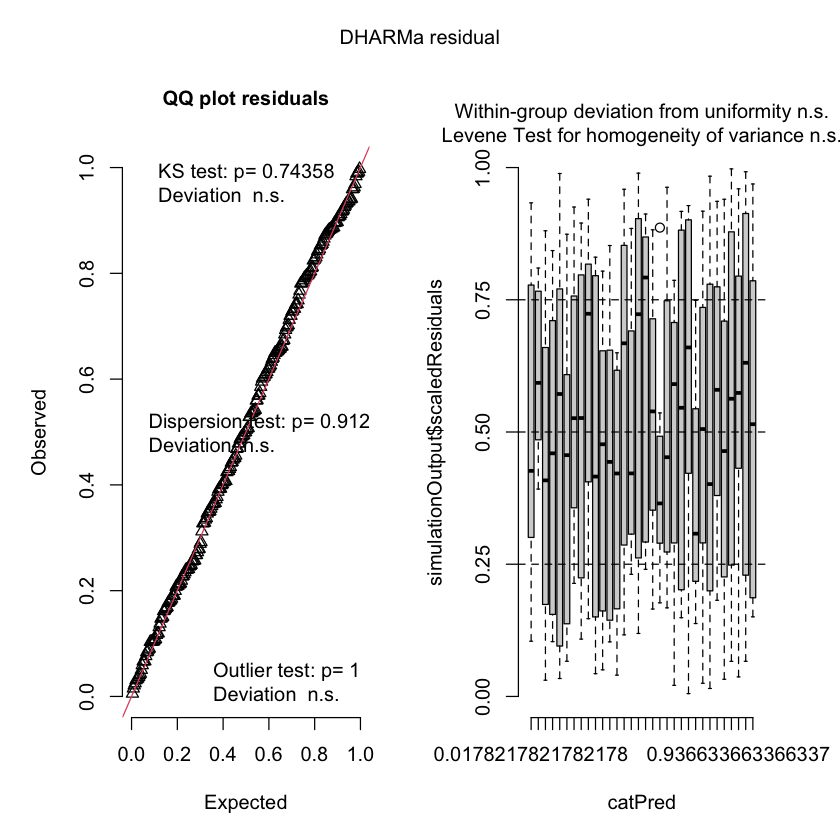

In [23]:
simres = simulateResiduals(mod1)
plot(simres, asFactor = T)

Yes, the diagnostic plots indicate the model is good
#### Model simplification

In [24]:
summary(mod1)
Anova(mod1)
drop.scope(mod1)


Correlation matrix not shown by default, as p = 19 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
Final_Decision_Binary ~ (Reward_Side + Solution + TSM_Bin + Visit)^2 +  
    (1 | Starvation_Period) + (1 | Collection_Date)
   Data: ELP_10
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1e+09))

     AIC      BIC   logLik deviance df.resid 
   351.0    425.5   -154.5    309.0      235 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.5117 -1.0267  0.4929  0.7307  1.5404 

Random effects:
 Groups            Name        Variance Std.Dev.
 Collection_Date   (Intercept) 0.002901 0.05386 
 Starvation_Period (Intercept) 0.000000 0.00000 
Number of obs: 256, groups:  Collection_Date, 8; Starvation_Period, 2

Fixed effects:
                                   Estimate Std. Error z value Pr(>|z|)  
(Intercept)                        0.365297   0.569776   0.641   0.5214  
Reward_SideR                      -0.385874   0.649668  -

,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
Reward_Side,1.096179e+00,1,0.29510625
Solution,5.188856e-06,1,0.99818250
TSM_Bin,2.535365e+00,1,0.11132117
Visit,1.054584e+01,3,0.01445311
Reward_Side:Solution,1.671884e+00,1,0.19600639
Reward_Side:TSM_Bin,7.166420e-01,1,0.39724761
Reward_Side:Visit,5.165106e-01,3,0.91524941
Solution:TSM_Bin,9.233958e-02,1,0.76122367
Solution:Visit,3.343785e+00,3,0.34159495


[1] "Reward_Side:Solution" "Reward_Side:TSM_Bin"  "Reward_Side:Visit"   
[4] "Solution:TSM_Bin"     "Solution:Visit"       "TSM_Bin:Visit"

In [25]:
mod2 = update(mod1, . ~ . - Reward_Side:Visit)
anova(mod1, mod2)

boundary (singular) fit: see ?isSingular



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
mod2,18,345.5646,409.3778,-154.7823,309.5646,NA,NA,NA
mod1,21,351.0427,425.4914,-154.5214,309.0427,0.5219049,3,0.9140533


mod1 is not significantly better than mod2 so we will keep mod2

In [26]:
summary(mod2)
Anova(mod2)
drop.scope(mod2)


Correlation matrix not shown by default, as p = 16 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: Final_Decision_Binary ~ Reward_Side + Solution + TSM_Bin + Visit +  
    (1 | Starvation_Period) + (1 | Collection_Date) + Reward_Side:Solution +  
    Reward_Side:TSM_Bin + Solution:TSM_Bin + Solution:Visit +  
    TSM_Bin:Visit
   Data: ELP_10
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1e+09))

     AIC      BIC   logLik deviance df.resid 
   345.6    409.4   -154.8    309.6      238 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.5950 -1.0132  0.5027  0.7134  1.5299 

Random effects:
 Groups            Name        Variance Std.Dev.
 Collection_Date   (Intercept) 0.00264  0.05138 
 Starvation_Period (Intercept) 0.00000  0.00000 
Number of obs: 256, groups:  Collection_Date, 8; Starvation_Period, 2

Fixed effects:
                                  Estimate Std. Error z value Pr(>|z|)  
(Intercept)                 

,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
Reward_Side,1.118935e+00,1,0.29014799
Solution,2.315431e-05,1,0.99616068
TSM_Bin,2.533223e+00,1,0.11147235
Visit,1.066131e+01,3,0.01370563
Reward_Side:Solution,1.693966e+00,1,0.19307902
Reward_Side:TSM_Bin,7.617143e-01,1,0.38279256
Solution:TSM_Bin,8.711271e-02,1,0.76788035
Solution:Visit,3.372491e+00,3,0.33768000
TSM_Bin:Visit,1.061402e+00,3,0.78639900


[1] "Reward_Side:Solution" "Reward_Side:TSM_Bin"  "Solution:TSM_Bin"    
[4] "Solution:Visit"       "TSM_Bin:Visit"

In [27]:
mod3 = update(mod2, . ~ . - TSM_Bin:Visit)
anova(mod2, mod3)

boundary (singular) fit: see ?isSingular



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
mod3,15,340.6342,393.8119,-155.3171,310.6342,NA,NA,NA
mod2,18,345.5646,409.3778,-154.7823,309.5646,1.069628,3,0.7844107


mod2 is not significantly better than mod3 so we will keep mod3

In [28]:
summary(mod3)
Anova(mod3)
drop.scope(mod3)


Correlation matrix not shown by default, as p = 13 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: Final_Decision_Binary ~ Reward_Side + Solution + TSM_Bin + Visit +  
    (1 | Starvation_Period) + (1 | Collection_Date) + Reward_Side:Solution +  
    Reward_Side:TSM_Bin + Solution:TSM_Bin + Solution:Visit
   Data: ELP_10
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1e+09))

     AIC      BIC   logLik deviance df.resid 
   340.6    393.8   -155.3    310.6      241 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.2929 -1.0026  0.4820  0.7173  1.4976 

Random effects:
 Groups            Name        Variance Std.Dev.
 Collection_Date   (Intercept) 0.002029 0.04505 
 Starvation_Period (Intercept) 0.000000 0.00000 
Number of obs: 256, groups:  Collection_Date, 8; Starvation_Period, 2

Fixed effects:
                                    Estimate Std. Error z value Pr(>|z|)  
(Intercept)                        4.126e-01  4.

,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
Reward_Side,1.115180e+00,1,0.29095873
Solution,1.486368e-05,1,0.99692389
TSM_Bin,2.595625e+00,1,0.10715917
Visit,1.095255e+01,3,0.01198525
Reward_Side:Solution,1.683768e+00,1,0.19442453
Reward_Side:TSM_Bin,7.651973e-01,1,0.38170692
Solution:TSM_Bin,8.181823e-02,1,0.77484836
Solution:Visit,3.342149e+00,3,0.34181930


[1] "Reward_Side:Solution" "Reward_Side:TSM_Bin"  "Solution:TSM_Bin"    
[4] "Solution:Visit"

In [29]:
mod4 = update(mod3, . ~ . - Solution:TSM_Bin)
anova(mod3, mod4)

boundary (singular) fit: see ?isSingular



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
mod4,14,338.7161,388.3485,-155.3580,310.7161,NA,NA,NA
mod3,15,340.6342,393.8119,-155.3171,310.6342,0.0818144,1,0.7748535


mod3 is not significantly better than mod4 so we will keep mod4

In [30]:
summary(mod4)
Anova(mod4)
drop.scope(mod4)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: Final_Decision_Binary ~ Reward_Side + Solution + TSM_Bin + Visit +  
    (1 | Starvation_Period) + (1 | Collection_Date) + Reward_Side:Solution +  
    Reward_Side:TSM_Bin + Solution:Visit
   Data: ELP_10
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1e+09))

     AIC      BIC   logLik deviance df.resid 
   338.7    388.3   -155.4    310.7      242 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.3059 -0.9862  0.4923  0.7283  1.4674 

Random effects:
 Groups            Name        Variance Std.Dev.
 Collection_Date   (Intercept) 0.003573 0.05977 
 Starvation_Period (Intercept) 0.000000 0.00000 
Number of obs: 256, groups:  Collection_Date, 8; Starvation_Period, 2

Fixed effects:
                                    Estimate Std. Error z value Pr(>|z|)  
(Intercept)                        3.777e-01  4.551e-01   0.830   0

,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
Reward_Side,1.116197e+00,1,0.29073878
Solution,2.918093e-05,1,0.99568990
TSM_Bin,2.596981e+00,1,0.10706746
Visit,1.098184e+01,3,0.01182451
Reward_Side:Solution,1.717631e+00,1,0.18999828
Reward_Side:TSM_Bin,7.924731e-01,1,0.37335335
Solution:Visit,3.306312e+00,3,0.34676515


[1] "Reward_Side:Solution" "Reward_Side:TSM_Bin"  "Solution:Visit"

In [31]:
mod5 = update(mod4, . ~ . - Reward_Side:TSM_Bin)
anova(mod4, mod5)

boundary (singular) fit: see ?isSingular



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
mod5,13,337.5111,383.5984,-155.7556,311.5111,NA,NA,NA
mod4,14,338.7161,388.3485,-155.3580,310.7161,0.7950745,1,0.3725701


mod4 is not significantly better than mod5 so we will keep mod5

In [32]:
summary(mod5)
Anova(mod5)
drop.scope(mod5)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: Final_Decision_Binary ~ Reward_Side + Solution + TSM_Bin + Visit +  
    (1 | Starvation_Period) + (1 | Collection_Date) + Reward_Side:Solution +  
    Solution:Visit
   Data: ELP_10
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1e+09))

     AIC      BIC   logLik deviance df.resid 
   337.5    383.6   -155.8    311.5      243 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.1790 -0.9474  0.5054  0.7014  1.3780 

Random effects:
 Groups            Name        Variance  Std.Dev. 
 Collection_Date   (Intercept) 5.728e-03 7.569e-02
 Starvation_Period (Intercept) 1.211e-14 1.100e-07
Number of obs: 256, groups:  Collection_Date, 8; Starvation_Period, 2

Fixed effects:
                                    Estimate Std. Error z value Pr(>|z|)  
(Intercept)                        4.913e-01  4.383e-01   1.121   0.2623  
Reward_S

,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
Reward_Side,1.135711e+00,1,0.28656051
Solution,1.799074e-05,1,0.99661574
TSM_Bin,2.637490e+00,1,0.10436832
Visit,1.096173e+01,3,0.01193462
Reward_Side:Solution,1.698347e+00,1,0.19250424
Solution:Visit,3.286086e+00,3,0.34958396


[1] "TSM_Bin"              "Reward_Side:Solution" "Solution:Visit"

In [33]:
mod6 = update(mod5, . ~ . - Solution:Visit)
anova(mod5, mod6)

boundary (singular) fit: see ?isSingular



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
mod6,10,334.8483,370.3001,-157.4242,314.8483,NA,NA,NA
mod5,13,337.5111,383.5984,-155.7556,311.5111,3.337181,3,0.3425011


mod5 is not significantly better than mod6 so we will keep mod6

In [34]:
summary(mod6)
Anova(mod6)
drop.scope(mod6)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: Final_Decision_Binary ~ Reward_Side + Solution + TSM_Bin + Visit +  
    (1 | Starvation_Period) + (1 | Collection_Date) + Reward_Side:Solution
   Data: ELP_10
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1e+09))

     AIC      BIC   logLik deviance df.resid 
   334.8    370.3   -157.4    314.8      246 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.3296 -1.0931  0.5382  0.7288  1.3171 

Random effects:
 Groups            Name        Variance Std.Dev.
 Collection_Date   (Intercept) 0.00299  0.05468 
 Starvation_Period (Intercept) 0.00000  0.00000 
Number of obs: 256, groups:  Collection_Date, 8; Starvation_Period, 2

Fixed effects:
                                  Estimate Std. Error z value Pr(>|z|)   
(Intercept)                         0.1182     0.3764   0.314  0.75349   
Reward_SideR                       -0.6

,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
Reward_Side,1.121216e+00,1,0.289656756
Solution,3.248667e-05,1,0.995452316
TSM_Bin,2.597113e+00,1,0.107058586
Visit,1.145989e+01,3,0.009482082
Reward_Side:Solution,1.808328e+00,1,0.178708963


[1] "TSM_Bin"              "Visit"                "Reward_Side:Solution"

In [35]:
mod7 = update(mod6, . ~ . - Reward_Side:Solution)
anova(mod6, mod7)

boundary (singular) fit: see ?isSingular



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
mod7,9,334.6647,366.5713,-158.3324,316.6647,NA,NA,NA
mod6,10,334.8483,370.3001,-157.4242,314.8483,1.81642,1,0.17774


mod6 is not significantly better than mod7 so we will keep mod7

In [36]:
summary(mod7)
Anova(mod7)
drop.scope(mod7)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: Final_Decision_Binary ~ Reward_Side + Solution + TSM_Bin + Visit +  
    (1 | Starvation_Period) + (1 | Collection_Date)
   Data: ELP_10
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1e+09))

     AIC      BIC   logLik deviance df.resid 
   334.7    366.6   -158.3    316.7      247 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.1270 -1.0423  0.5670  0.7142  1.2232 

Random effects:
 Groups            Name        Variance Std.Dev.
 Collection_Date   (Intercept) 0.008603 0.09275 
 Starvation_Period (Intercept) 0.000000 0.00000 
Number of obs: 256, groups:  Collection_Date, 8; Starvation_Period, 2

Fixed effects:
                      Estimate Std. Error z value Pr(>|z|)   
(Intercept)          -0.071504   0.345395  -0.207  0.83599   
Reward_SideR         -0.290528   0.270637  -1.073  0.28305   
Solution0.734mM GABA -0.

,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
Reward_Side,1.152392e+00,1,0.283049064
Solution,7.104175e-05,1,0.993275008
TSM_Bin,2.588365e+00,1,0.107651403
Visit,1.140048e+01,3,0.009746212


[1] "Reward_Side" "Solution"    "TSM_Bin"     "Visit"

Ants seem to do significantly better at visit 4 and even better at visit 5. Other worth to mention results from the model summary include a slight, yet not significant, decrease in learning success under 0.734mM GABA. Collection_Date explains a small amount of variance in the data but not Starvation_Period.

,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
mod7,9,334.6647,366.5713,-158.3324,316.6647,NA,NA,NA
mod1,21,351.0427,425.4914,-154.5214,309.0427,7.622023,12,0.8139269


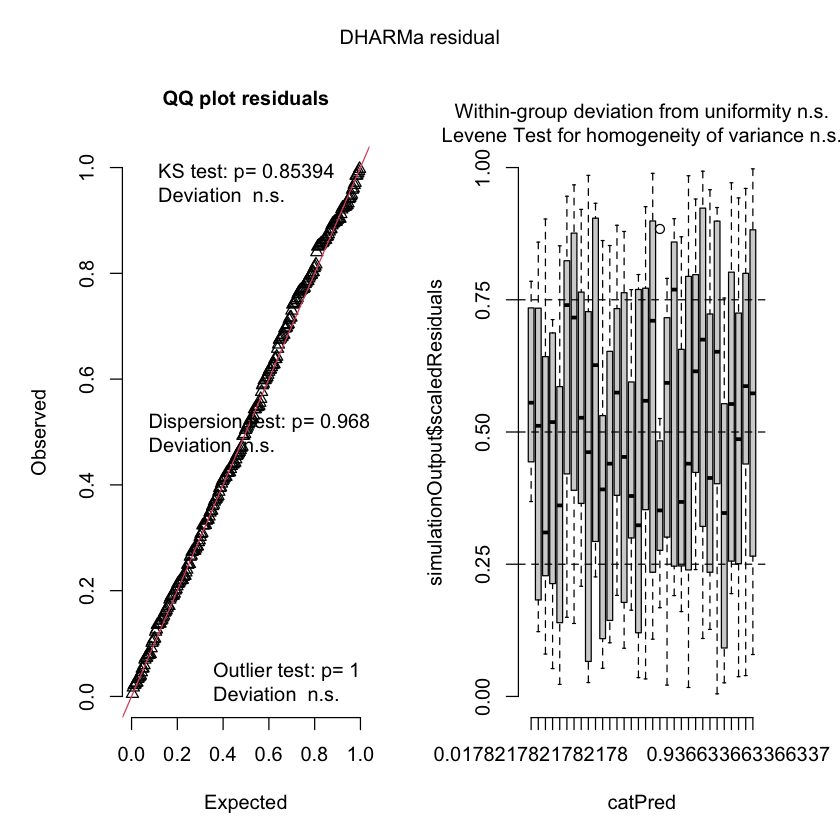

In [37]:
anova(mod1, mod7)
simres = simulateResiduals(mod7)
plot(simres, asFactor = T)

mod1 is not significantly better than mod7 so we will keep mod7 - the diagnostic plots suggest mod7 is still a good fit.

#### Model interpretation
There is an effect of visit:

In [38]:
meanobj = emmeans(mod7, ~Visit, type = "response")
pairs(meanobj, adjust = "bonferroni")

 contrast odds.ratio    SE  df null z.ratio p.value
 2 / 3         0.636 0.230 Inf    1  -1.253  1.0000
 2 / 4         0.355 0.136 Inf    1  -2.712  0.0401
 2 / 5         0.327 0.126 Inf    1  -2.897  0.0226
 3 / 4         0.559 0.215 Inf    1  -1.511  0.7850
 3 / 5         0.514 0.200 Inf    1  -1.707  0.5266
 4 / 5         0.920 0.375 Inf    1  -0.204  1.0000

Results are averaged over the levels of: Reward_Side, Solution, TSM_Bin 
P value adjustment: bonferroni method for 6 tests 
Tests are performed on the log odds ratio scale 

Ants are significantly more successful at learning at visit 4 and 5 when compared to visit 2 but not visit 3.

In [39]:
meanobj = emmeans(mod7, ~TSM_Bin * Visit, type = "response")
test(meanobj)

,TSM_Bin,Visit,prob,SE,df,null,z.ratio,p.value
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0-30,2,0.4457372,0.07124338,Inf,0.5,-0.7556594,4.498534e-01
2,30-60,2,0.5545014,0.07129924,Inf,0.5,0.7583338,4.482512e-01
3,0-30,3,0.5585238,0.07172530,Inf,0.5,0.8084703,4.188199e-01
4,30-60,3,0.6619413,0.06658272,Inf,0.5,2.2583532,2.392365e-02
5,0-30,4,0.6936033,0.06635209,Inf,0.5,2.6168150,8.875444e-03
6,30-60,4,0.7779577,0.05615913,Inf,0.5,3.8565681,1.149901e-04
7,0-30,5,0.7109284,0.06516294,Inf,0.5,2.8380730,4.538680e-03
8,30-60,5,0.7919437,0.05447121,Inf,0.5,4.0433014,5.270381e-05


All visits/time since marking combinations are significantly different than chance (50%) except for:
- Visit 2: 0-30 & 30-60
- Visit 3: 0-30

It is interesting to note that all probabilities associated with visits at 30-60 minutes after marking are higher than their 0-30 counterparts - though this is likely not significant.

In [40]:
meanobj = emmeans(mod7, ~Solution, type = "response")
test(meanobj)
pairs(meanobj, adjust = "bonferroni")

,Solution,prob,SE,df,null,z.ratio,p.value
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Control,0.6577041,0.04425346,Inf,0.5,3.322393,0.0008924898
2,0.734mM GABA,0.6571897,0.04392449,Inf,0.5,3.337969,0.0008439313


 contrast               odds.ratio    SE  df null z.ratio p.value
 Control / 0.734mM GABA          1 0.272 Inf    1   0.008  0.9933

Results are averaged over the levels of: Reward_Side, TSM_Bin, Visit 
Tests are performed on the log odds ratio scale 

There was **no significant difference between control and 0.734mM GABA** solutions suggesting GABA has little to no effect on the ants ability to associate a reward with a side of the Y-maze.

In [41]:
meanobj = emmeans(mod7, ~1, type = "response")
test(meanobj)

,1,prob,SE,df,null,z.ratio,p.value
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,overall,0.6574469,0.0318234,Inf,0.5,4.613684,3.955943e-06


Overall, the ants successfully associated the presence of a reward with a side of the Y-maze with a **66%** success rate, a percentage significantly different from chance level (50%).

In [42]:
sessionInfo()

R version 4.1.0 (2021-05-18)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Big Sur 10.16

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.1/Resources/lib/libRblas.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.1/Resources/lib/libRlapack.dylib

locale:
[1] C/UTF-8/C/C/C/C

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] emmeans_1.7.3  car_3.0-12     carData_3.0-5  DHARMa_0.4.5   lme4_1.1-27.1 
[6] Matrix_1.3-3   reshape2_1.4.4

loaded via a namespace (and not attached):
 [1] gap_1.2.3-1         Rcpp_1.0.7          pillar_1.6.3       
 [4] compiler_4.1.0      nloptr_1.2.2.2      plyr_1.8.7         
 [7] base64enc_0.1-3     tools_4.1.0         boot_1.3-28        
[10] digest_0.6.28       uuid_0.1-4          jsonlite_1.7.2     
[13] evaluate_0.14       lifecycle_1.0.1     nlme_3.1-152       
[16] lattice_0.20-44     rlang_0.4.11        IRdisplay_1.0      
